In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m/keras/bert/keras/bert_base_en_uncased/2/config.json
/kaggle/input/m/keras/bert/keras/bert_base_en_uncased/2/tokenizer.json
/kaggle/input/m/keras/bert/keras/bert_base_en_uncased/2/metadata.json
/kaggle/input/m/keras/bert/keras/bert_base_en_uncased/2/model.weights.h5
/kaggle/input/m/keras/bert/keras/bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001
/kaggle/input/gnews-swivel/tensorflow2/tf2-preview-20dim/1/saved_model.pb
/kaggle/input/gnews-sw

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_nlp
from transformers import AutoTokenizer, TFBertForSequenceClassification, BertTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
import re
import nltk
nltk.download('punkt')  


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)



2025-05-25 16:16:02.370092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748189762.599683      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748189762.666905      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [4]:
train = train.drop(['id', 'location', 'keyword'], axis=1)

In [5]:
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [7]:
train.info()
print('-------------------------------------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
def missing_percentage(df):
    print((df.isna().sum().sort_values(ascending=False)/df.shape[0])*100) 


missing_percentage(train)
print('-----------------------------------------')
missing_percentage(test)

text      0.0
target    0.0
dtype: float64
-----------------------------------------
location    33.864542
keyword      0.796813
id           0.000000
text         0.000000
dtype: float64


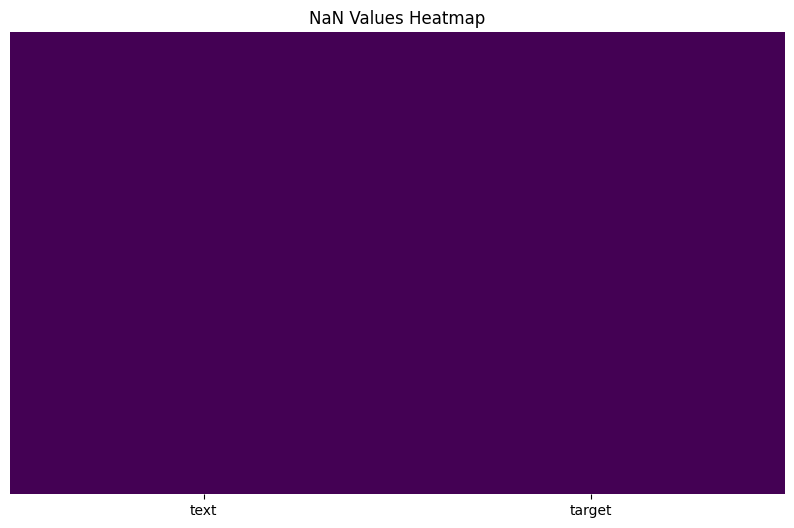

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("NaN Values Heatmap")
plt.show()

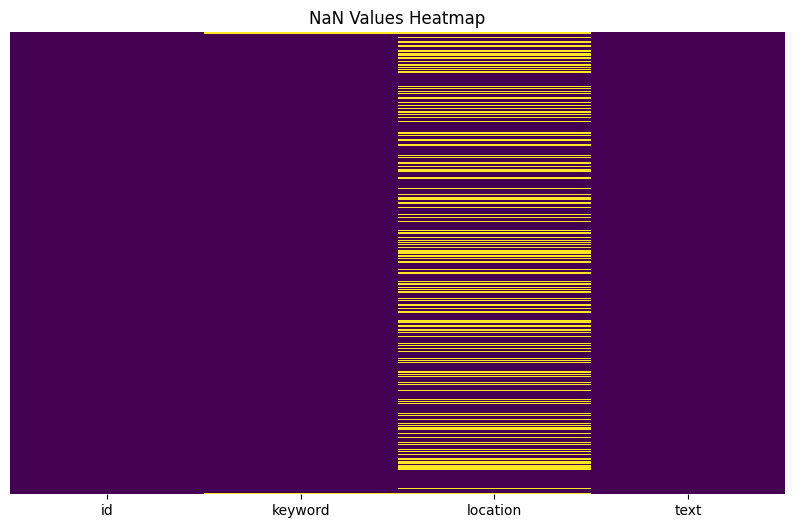

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(test.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("NaN Values Heatmap")
plt.show()

In [11]:
train

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


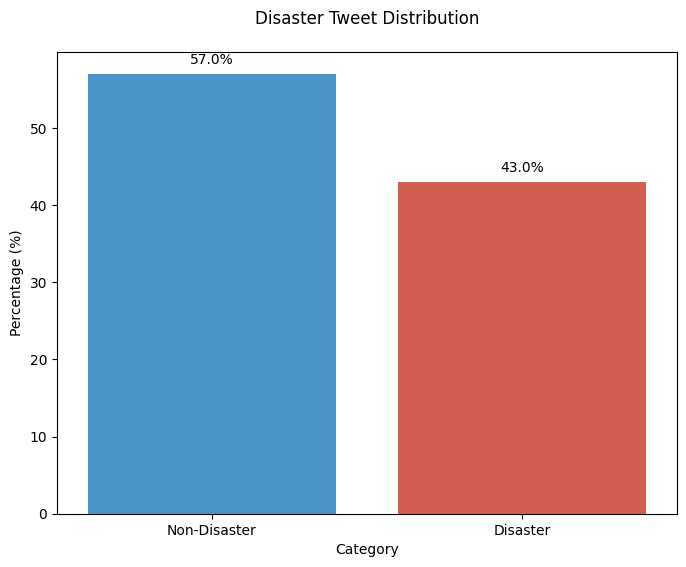

In [12]:
# Calculate percentages
value_counts = train['target'].value_counts(normalize=True) * 100

# Create figure
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=value_counts.index, 
                 y=value_counts.values, 
                 palette=['#3498db', '#e74c3c'])

# Add percentages on top
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Customize
plt.title('Disaster Tweet Distribution', pad=20)
plt.xlabel('Category')
plt.ylabel('Percentage (%)')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
#plt.ylim(0, 100)
plt.show()

# Data prep

In [13]:
print(train.sample(n=20).to_string(index=False))

                                                                                                                                     text  target
                                                                                                                      Get that hazard pay       0
                                                                                                                        Emergency surgery       0
                 @Camilla_33 @CrayKain Hate to shatter your delusions but a hatchet is a deadly weapon justifying lethal force. #gunsense       0
 Route Complex AM Fire Update (Route Complex Wildfire): FIRE UPDATE: ROUTE COMPLEX Thursday Morning Aug... http://t.co/nS5lBS5ZUp #CAFire       1
                                  People are more worried about the burning of buildings than black people losing their lives disgusting.       1
Worlds Collide When an American Family Takes Over Britain's Isle of Man in New TLC Show Suddenly Royal http://t.co/OmB3oS54t

## data processing

In [14]:
def text_preprocess(text):
    #Remove all URLs from text
    text= re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text= re.sub(r"#(\w+)", r"\1", text)
    #text= re.sub(r"[^\w\s{'}]|_", '', text)
    text= re.sub(r'[^\w\s]', '', text)
    text= re.sub(r'\n', ' ', text)
    text= re.sub(r'\d+', '', text)
    text
    
    return text.lower().strip()

In [15]:
stemmer = SnowballStemmer('english')

def text_preprocess_with_stemming(text):
    """
    Enhanced text preprocessing with stemming for tweet classification.
    Handles URLs, hashtags, punctuation, numbers, and applies stemming.
    
    Args:
        text (str): Raw tweet text
        
    Returns:
        str: Processed and stemmed text
    """
    # Step 1: Basic cleaning
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r"#(\w+)", r"\1", text)  # Remove hashtag symbol but keep text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (keep underscores)
    text = re.sub(r'\n', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    
    # Step 2: Case normalization
    text = text.lower().strip()
    
    # Step 3: Tokenization and stemming
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(stemmed_tokens)


In [16]:
train_df = train.copy()

train_df['clean_text'] = train_df['text'].apply(text_preprocess_with_stemming)

In [17]:
print(train_df[['clean_text', 'text']].sample(n=20))

                                                                                                                   clean_text  \
2065                                                     naaa i bee dead like a legit zombi i feel everi sore part in my bodi   
226           day of tryout went good minus the fact i stop quick to get a short ball and annihil my toenail injuri even more   
7534                                 wreckag conclus confirm as from mh malaysia pm investig and the famili of those who were   
5474                                            reddit updat content polici promis to quarantin ûextrem offensiveûª communiti   
7172                                                                                       greedi had me in the war zone lmao   
241                     a fun fill happyhour at simmon bar in camden with this handsom one i got annihil apart from this game   
3090           no but serious i will electrocut half of uk armi so i can touch bangtan i do not p

# Model training

In [18]:

#X = train_df.drop(columns=['target'])
X = train_df['clean_text']
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate classification model with key metrics and visualizations
    
    Parameters:
    y_true (array): True labels
    y_pred (array): Predicted labels
    model_name (str): Name for display purposes
    """
    # Calculate metrics
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # Print metrics
    print(f"╔{'═'*30}╗")
    print(f"║ {model_name.upper():^28} ║")
    print(f"╠{'═'*30}╣")
    print(f"║ {'F1 Score:':<15} {f1:.4f}{'║':>9}")
    print(f"║ {'Precision:':<15} {precision:.4f}{'║':>9}")
    print(f"║ {'Recall:':<15} {recall:.4f}{'║':>9}")
    print(f"╚{'═'*30}╝\n")
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Disaster', 'Disaster'],
                yticklabels=['Non-Disaster', 'Disaster'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {'f1': f1, 'precision': precision, 'recall': recall}

# Usage example:
# y_true = test_df['target']
# y_pred = model.predict(X_test)
# metrics = evaluate_model(y_true, y_pred, "Disaster Tweet Classifier")

## TF IDF

### 1

In [20]:
model = make_pipeline(
    TfidfVectorizer(stop_words='english', max_df= 0.7, max_features= 10000, min_df= 1, ngram_range= (1, 1), norm= 'l2'),  # Text to numbers
    RandomForestClassifier(n_estimators = 500, class_weight='balanced', min_samples_leaf= 2) 
)

# Train (X_train = tweets, y_train = labels)
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=10000,
                                 stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2,
                                        n_estimators=500))])

╔══════════════════════════════╗
║       TRAIN DATA TF-IDF      ║
╠══════════════════════════════╣
║ F1 Score:       0.8694        ║
║ Precision:      0.8640        ║
║ Recall:         0.8749        ║
╚══════════════════════════════╝



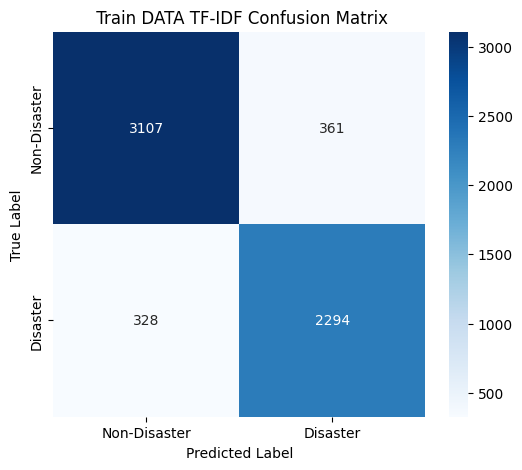

In [21]:
y_train_pred = model.predict(X_train)
metrics = evaluate_model(y_train, y_train_pred, " Train DATA TF-IDF")

╔══════════════════════════════╗
║       TEST DATA TF-IDF       ║
╠══════════════════════════════╣
║ F1 Score:       0.7393        ║
║ Precision:      0.7118        ║
║ Recall:         0.7689        ║
╚══════════════════════════════╝



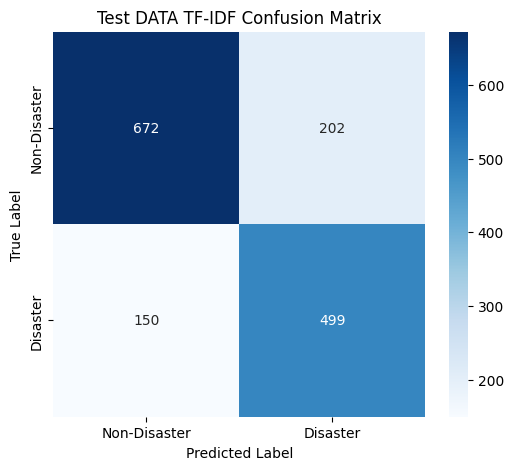

In [22]:
y_pred = model.predict(X_test)
metrics = evaluate_model(y_test, y_pred, "Test DATA TF-IDF")

### Word Embedding


In [23]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
X_padded = pad_sequences(train_sequences, maxlen=70, padding='post', truncating='post')


y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [24]:
model = Sequential([
    # Input Layer
    Embedding(input_dim=10000, output_dim=128, input_length=30),
    # Convolutional Block (Multiple filter sizes)
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    # Parallel Bidirectional LSTMs
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    # Combined Features
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Output Layer
    Dense(1, activation='sigmoid')
])

I0000 00:00:1748189807.249379      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748189807.250137      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [25]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy', AUC(name='auc')]
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=100
)

Epoch 1/50


I0000 00:00:1748189816.018283      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.6147 - auc: 0.5943 - loss: 0.6585 - val_accuracy: 0.7754 - val_auc: 0.8412 - val_loss: 0.4864
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8434 - auc: 0.9098 - loss: 0.3713 - val_accuracy: 0.7945 - val_auc: 0.8548 - val_loss: 0.4656
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9206 - auc: 0.9626 - loss: 0.2251 - val_accuracy: 0.7735 - val_auc: 0.8437 - val_loss: 0.5565
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9464 - auc: 0.9791 - loss: 0.1614 - val_accuracy: 0.7676 - val_auc: 0.8284 - val_loss: 0.6404
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9668 - auc: 0.9887 - loss: 0.1136 - val_accuracy: 0.7505 - val_auc: 0.8274 - val_loss: 0.7440
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9743 - auc: 0.9912 - loss: 0.0889 - val_accuracy: 0.7656 - val_auc: 0.8246 - val_loss: 0.7556
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
╔══════════════════════════════╗
║        TEST EMBEDDING        ║
╠══════════════════════════════╣
║ F1 Score:       0.6929        ║
║ Precision:      0.7244        ║
║ Recall:         0.6641        ║
╚══════════════════════════════╝



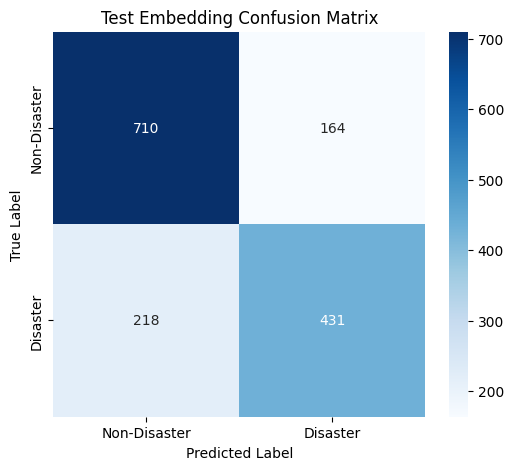

In [26]:
y_pred = model.predict(X_test)
y_pred_thresh = (y_pred > 0.47).astype(int)
metrics = evaluate_model(y_test, y_pred_thresh, "Test Embedding")

## BERT

In [27]:
train_df = train.copy()

train_df['clean_text'] = train_df['text'].apply(text_preprocess)

In [28]:

#X = train_df.drop(columns=['target'])
X = train_df['clean_text']
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [30]:
# Initialize preprocessor
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_base_en_uncased",
    sequence_length=128
)

# Get ALL required BERT inputs (token_ids, segment_ids, padding_mask)
def preprocess_text(text):
    output = preprocessor(text)
    return {
        "token_ids": output["token_ids"],
        "segment_ids": output["segment_ids"],  # ← MISSING IN YOUR CODE
        "padding_mask": output["padding_mask"]
    }

# Preprocess all data
preprocessed = [preprocess_text(t) for t in X_train]

dataset = tf.data.Dataset.from_tensor_slices((
    {
        "token_ids": np.stack([x["token_ids"] for x in preprocessed]),
        "segment_ids": np.stack([x["segment_ids"] for x in preprocessed]),  # ← ADDED
        "padding_mask": np.stack([x["padding_mask"] for x in preprocessed])
    },
    y_train
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [31]:
# Define model inputs (numeric only!)
inputs = {
    "token_ids": tf.keras.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
     "segment_ids": tf.keras.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
    "padding_mask": tf.keras.Input(shape=(128,), dtype=tf.int32, name="padding_mask")
}

# BERT encoder
encoder = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")
outputs = encoder(inputs)

# Classification head
pooled_output = outputs["pooled_output"]  # [batch_size, 768]

Dence_layer = tf.keras.layers.Dense(64, activation='relu')(pooled_output)


predictions = tf.keras.layers.Dense(1, activation="sigmoid")(Dence_layer)

# Compile
model = tf.keras.Model(inputs=inputs, outputs=predictions)
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 768), (None,   │    109,482,240 │ padding_mask[0][0],    │
│ (BertBackbone)            │ 128, 768)]             │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │         49,216 │ bert_backbone[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 109,531,521 (417.83 MB)

 Trainable params: 109,531,521 (417.83 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# 4. Training the Model
history = model.fit(
    dataset,
    epochs=20
    #validation_data=test_dataset
)

Epoch 1/20


I0000 00:00:1748190133.885170      63 service.cc:148] XLA service 0x793f705d59a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748190133.886369      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748190133.886390      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748190164.371857      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 259s 948ms/step - accuracy: 0.7760 - loss: 0.4950
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 158s 826ms/step - accuracy: 0.8703 - loss: 0.3251
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 173s 906ms/step - accuracy: 0.9143 - loss: 0.2362
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 171s 895ms/step - accuracy: 0.9326 - loss: 0.1870
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 159s 834ms/step - accuracy: 0.9525 - loss: 0.1283
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 157s 822ms/step - accuracy: 0.9566 - loss: 0.1010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 156s 819ms/step - accuracy: 0.9722 - loss: 0.0677
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 156s 819ms/step - accuracy: 0.9786 - loss: 0.0597
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 157s 820ms/step - accuracy: 0.9816 - loss: 0.0425
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 161s 845ms/step - accuracy: 0.9792 - loss: 0.0428
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 173s 905ms/step - accuracy: 0.9812 - loss: 0.0426
Epoch 12/20
191/191

In [34]:
def predict(text):
    preprocessed = preprocessor(text)
    return model.predict({
        "token_ids": tf.expand_dims(preprocessed["token_ids"], 0),
        "segment_ids": tf.expand_dims(preprocessed["segment_ids"], 0), 
        "padding_mask": tf.expand_dims(preprocessed["padding_mask"], 0)
    }
                         ,verbose=0)[0][0]

In [35]:
y_pred = [predict(t) for t in X_test]

In [36]:
np.array(y_pred) 

array([8.6641945e-03, 6.6525608e-05, 9.9996257e-01, ..., 9.9994349e-01,
       9.9997926e-01, 9.7307712e-01], dtype=float32)

╔══════════════════════════════╗
║        BERT EMBEDDING        ║
╠══════════════════════════════╣
║ F1 Score:       0.7776        ║
║ Precision:      0.7964        ║
║ Recall:         0.7596        ║
╚══════════════════════════════╝



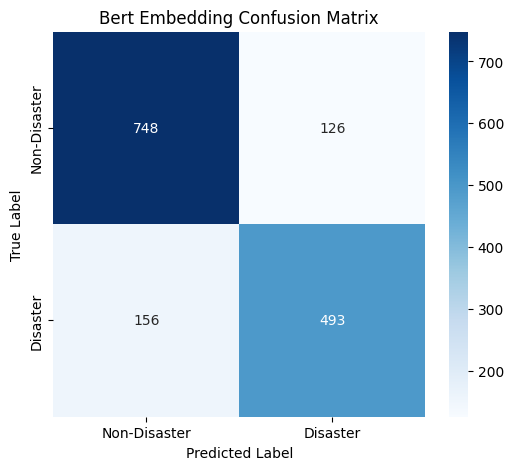

In [37]:
y_pred_thresh = (np.array(y_pred)  > 0.72).astype(int)
metrics = evaluate_model(y_test, y_pred_thresh, "Bert Embedding")

In [38]:
def create_kaggle_submission(
    pipeline,  # Your sklearn Pipeline (includes preprocessor + model)
    test_data,  # test data
    sample_sub,  # Kaggle's sample submission
    output_file="submission.csv",  # Output filename
    id_column="id",  # Name of ID column (e.g., 'PassengerId', 'Id')
    target_column="target"  # Name of target column (e.g., 'Survived')
):
    """
    Creates a Kaggle submission file using a pre-fitted sklearn Pipeline.
    
    Args:
        pipeline: Fitted sklearn Pipeline (preprocessor + model).
        test_file_path (str): Path to test data CSV.
        sample_submission_path (str): Path to sample submission CSV.
        output_file (str): Output submission filename.
        id_column (str): Name of the ID column in test data.
        target_column (str): Name of the target column in sample submission.
    """

    
    ids = test_data[id_column]
    
    if id_column in test_data.columns:
        test_features = test_data.drop(columns=[id_column])
    else:
        test_features = test_data
    
    predictions = predict(test_features)
    
    
    sample_sub[target_column] = predictions

    
    # Save to CSV
    sample_sub.to_csv(output_file, index=False)
    print(f"✅ Submission file saved as '{output_file}'")
    print(f"📊 Sample submission head:\n{sample_sub.head()}")